A [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine) is a generative stochastic artificial neural network that can learn a probability distribution over its set of inputs. 

A standard RBM has following diagram

<img src="./assets/rbm-diagram.png" alt="rbm-diagram" style="width: 40%; height: 40%">

where we denote
* $v\in\mathbb{R}^D$ is visible units
* $h\in\mathbb{R}^H$ is hidden units

And $v,h$ takes binary value (0,1), then it defines an energy function (similar as Hopfield network)
$$
E(v,h) = -a^Tv -b^Th - v^TWh
$$
which allows us to model the joint-distribution $(v,h)$ in term of the energy function i.e
$$
P(v,h) = \frac{1}{Z}e^{-E(v,h)}
$$
where $Z$ is normalized constant i.e
$$
Z = \sum_{v,h}e^{-E(v,h)}
$$

The above diagram is a bipartite graph which allows to define conditional probability 
$$
\begin{split}
P(v|h) &= \prod_{i=1}^DP(v_i|h)\\
P(h|v) &= \prod_{j=1}^HP(h_j|v)
\end{split}
$$
where individual probability is given by
$$
\begin{array}{rl}
P(v_i=1|h) &= \sigma\left(a_i + \sum_{j=1}^{H}w_{i,j}h_j\right)\\
P(h_j=1|v) &= \sigma\left(b_j + \sum_{i=1}^Dw_{i,j}v_i\right)
\end{array}
$$

### RBM task
In this note, we look at the following task
* given a set of unlabelled dataset $\left\{v^{(i)}\right\}_{i=1}^n$
* given a configuration of RMB e.g number of hidden units $H$

The goal is to learn $a$, $b$ and $W$ that model the joint-distribution directly from dataset $\left\{v^{(i)}\right\}_{i=1}^n$ i.e that maximize the sum of log-likelihood
$$
\sum_{i=1}^n\log\left(P(v^{(i)})\right)
$$
where 
$$
P(v) = \sum_{h}P(v,h)=\frac{1}{Z}\sum_{h}e^{-E(v,h)}
$$

### How to train RBM
The learning for RBM is difficult since computation of $Z$ is exponentially hard, however we have the following interesting fact

$$
\begin{split}
\frac{\partial \log P(v)}{\partial w_{i,j}} &= \langle v_i,h_j\rangle_{data} - \langle v_i,h_j\rangle_{model}\\
\frac{\partial \log P(v)}{\partial a_i} &= \langle v_i\rangle_{data} - \langle v_i\rangle_{model} \\
\frac{\partial \log P(v)}{\partial b_j} &= \langle h_j\rangle_{data} - \langle h_j\rangle_{model}
\end{split}
$$

where
* $\langle v_i, h_j\rangle_{data}$ is expected value of the product when $v$ is clamped on data (i.e $v_i$ is taken from training dataset)
* $\langle v_i, h_j\rangle_{model}$ is expected value of the product when $v,h$ is generated by model
* $\langle v_i\rangle_{data}, \langle h_j\rangle_{data}, \langle v_i\rangle_{model}, \langle h_j\rangle_{model}$ are defined similarly

Now let's look at how we compute $\langle v_i,h_j\rangle_{data}$ and $\langle v_i,h_j\rangle_{model}$, it's done via two phases
* **positive phase**: clamp a datavector on the visible units, then we sample $h$ and compute the average $\langle v,h\rangle $
* **negative phase**: keep a set of fantasy particles $v$ where each particle has a value that is a global configuration, then we sample $h$ and compute the average $\langle v,h\rangle $

To illustrate the process, we show the following diagram is taken from G. Hinton's course (NN)
<img src="./assets/rbm-pos-neg.png" alt="rbm-pos-neg" style="width: 60%; height: 50%">

and the update rule for $W$
$$
\Delta w_{i,j} = \epsilon\left( \langle v_i,h_j\rangle^0 - \langle v_i,h_j\rangle^\infty \right)
$$
This is actually based on Markov Chain Monte Carlo (MCMC) and Gibbs sampling. However this's still not efficient enough. 
 
Fortunately, G. Hinton introduces a very fast learning algorithm so called **Constrative Divergence Learning** where we can use a short cut
<img src="./assets/rbm-cd-learning.png" alt="rbm-cd-learning" style="width: 60%; height: 50%">
we denote 
$$
CD_1 = \langle v_i,h_j\rangle^0 - \langle v_i,h_j\rangle^1
$$
we can similarly define $CD_t = \langle v_i,h_j\rangle^0 - \langle v_i,h_j\rangle^t$, so the update rule can be written as
$$
\begin{split}
\Delta w_{i,j} &= \epsilon CD_1\\
\Delta a_i &= \epsilon\left(\langle v_i\rangle^0 - \langle v_i\rangle^1\right)\\
\Delta b_j &= \epsilon\left(\langle h_j\rangle^0 - \langle h_i\rangle^1\right)
\end{split}
$$

One can see that the learning doesn't use the correct gradient of the log-likelihood, as suggested by G. Hinton, we can use the following process
* start with small weight $w_{i,j}$
* for the first few iteration and we use $CD_1$
* then after some number of iterations, we can use $CD_3$, then $CD_{10}$

## Implement RBM
It's time to implement RBM for the above task, we will consider MNIST dataset for this task, then later we go through some RBM's application.

First we load needed modules

In [5]:
import numpy as np
import sys

# add parent to search path
if '..' not in sys.path:
    sys.path.insert(0, '..')

    
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

from helpers import rbm

Now let's download MNIST dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('.', one_hot=True, reshape=False)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


Let's inspect the data a bit

number of training point: 55000
shape of training data:   (55000, 28, 28, 1)


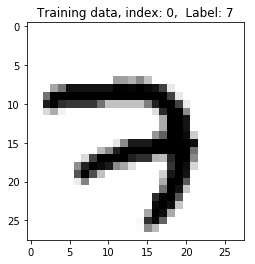

In [62]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

print('number of training point:', mnist.train.num_examples)
print('shape of training data:  ', mnist.train.images.shape)

labels = np.argwhere(mnist.train.labels==1)[:,1]

def draw_digit(image, label, index):
    plt.title('Training data, index: {},  Label: {}'.format(index, label))
    plt.imshow(image, cmap='gray_r')
    plt.show()

# Function for displaying a training image by it's index in the MNIST set
def show_digit(dataset, labels, index):
    label = labels[index].argmax(axis=0)
    # Reshape 784 array into 28x28 image
    image = dataset[index].reshape([28,28])    
    draw_digit(image, label, index)

plt.figure(2)
show_digit(mnist.train.images, mnist.train.labels, 0)   

# let reshape data
train_X = np.reshape(mnist.train.images,      [-1, 28*28])
valid_X = np.reshape(mnist.validation.images, [-1, 28*28])

train_y = mnist.train.labels
valid_y = mnist.validation.labels

Let's train MNIST using RBM

In [119]:
num_hiddens = 200
rbm_model = rbm.RBMachine(train_X.shape[1], num_hiddens)

epochs = 20
batch_size = 128
learning_rate = 1e-1
rbm_model.train(train_X, valid_X, epochs, batch_size, learning_rate, cd_steps=1, use_pcd = True)

Epoch (1/20)Step   400 Loss 0.0662 

Epoch (2/20)Step   850 Loss 0.0578 

Epoch (3/20)Step  1250 Loss 0.0542 

Epoch (4/20)Step  1700 Loss 0.0515 

Epoch (5/20)Step  2100 Loss 0.0498 

Epoch (6/20)Step  2550 Loss 0.0486 

Epoch (7/20)Step  3000 Loss 0.0462 

Epoch (8/20)Step  3400 Loss 0.0458 

Epoch (9/20)Step  3850 Loss 0.0455 

Epoch (10/20)Step  4250 Loss 0.0445 

Epoch (11/20)Step  4700 Loss 0.0441 

Epoch (12/20)Step  5100 Loss 0.0436 

Epoch (13/20)Step  5550 Loss 0.0430 

Epoch (14/20)Step  6000 Loss 0.0427 

Epoch (15/20)Step  6400 Loss 0.0421 

Epoch (16/20)Step  6850 Loss 0.0414 

Epoch (17/20)Step  7250 Loss 0.0415 

Epoch (18/20)Step  7700 Loss 0.0408 

Epoch (19/20)Step  8150 Loss 0.0406 

Epoch (20/20)Step  8550 Loss 0.0404 




### Visualize RBM re-construction phase
We can use RBM to re-construct the input from hidden layer

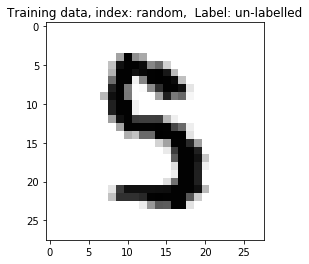

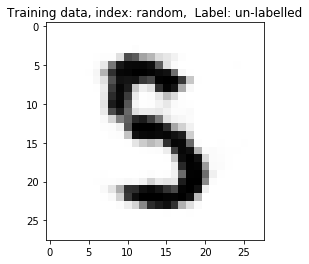

In [114]:
i = np.random.randint(valid_X.shape[0])
v0 = valid_X[i]

v1_probs, v1 = rbm_model.sample(v0, num_gibbs_step=1)

plt.figure(1)
draw_digit(np.reshape(v0,[28,28]), 'un-labelled', 'random')
plt.figure(2)
draw_digit(np.reshape(v1_probs,[28,28]), 'un-labelled', 'random')

### Visualize RBM as generative model

Let's try using Gibbs sampling
$$
\begin{array}{rcl}
v_0 & =&\text{randomly selected from validation-set or test-set}\\
v_i & =& \mathrm{gibbs}_{sampling}(v_{i-1})
\end{array}
$$
then for $n$ big enough we have
$$
v_n \sim P(v)
$$

Let's try with $n=500$ Gibbs steps

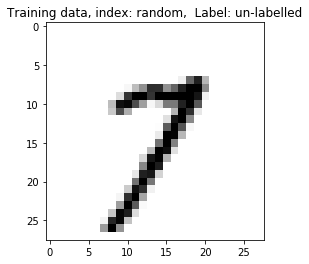

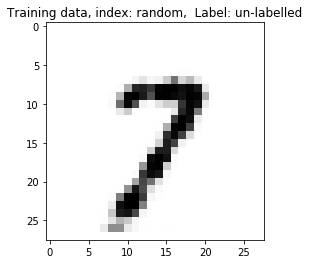

In [116]:
i = np.random.randint(valid_X.shape[0])
v0 = valid_X[i]
v_probs, v = rbm_model.sample(v0, num_gibbs_step=500)
plt.figure(1)
draw_digit(np.reshape(v0,[28,28]), 'un-labelled', 'random')
plt.figure(2)
draw_digit(np.reshape(v_probs,[28,28]), 'un-labelled', 'random')

## RBM applications

We can see the re-construction is not very clear but still keeps similar shape/constrat. Based on this properties, RBM can be applied in
* Dimension reduction: as seen above we can use 100 hidden units as a compression of input image (756) and we can re-construct the input from hidden unit.
* Feature learning: we can use 100 hidden units as features for example in classification e.g we use the hidden units in MNIST recognition tasks to see if we obtain a good accuracy.

### MNIST feature learning

After RBM is trained, we can use the mean activation $p(h_j=1|v)$ of the hidden layer as a representation of the data, then we train MNIST classification on that representation.

In [118]:
epochs = 500
batch_size = 128
##
rbm_model.train_classification(train_X, train_y, valid_X, valid_y, epochs, batch_size, learning_rate=1e-1)

Epoch (   1/ 500)Step    400 Loss 9.7097 Accuracy 56.92%%

Epoch (  25/ 500)Step  10700 Loss 1.6911 Accuracy 90.36%%

Epoch (  50/ 500)Step  21450 Loss 1.2404 Accuracy 92.30%

Epoch (  75/ 500)Step  32150 Loss 1.1578 Accuracy 93.02%

Epoch ( 100/ 500)Step  42900 Loss 0.9918 Accuracy 93.76%

Epoch ( 125/ 500)Step  53600 Loss 1.5491 Accuracy 94.42%

Epoch ( 150/ 500)Step  64350 Loss 0.3002 Accuracy 94.60%

Epoch ( 175/ 500)Step  75050 Loss 0.5762 Accuracy 94.62%

Epoch ( 200/ 500)Step  85800 Loss 0.6332 Accuracy 94.76%

Epoch ( 225/ 500)Step  96500 Loss 1.1959 Accuracy 94.96%

Epoch ( 250/ 500)Step 107250 Loss 0.8469 Accuracy 95.12%

Epoch ( 275/ 500)Step 117950 Loss 0.4703 Accuracy 95.32%

Epoch ( 300/ 500)Step 128700 Loss 0.0652 Accuracy 95.38%

Epoch ( 325/ 500)Step 139400 Loss 0.3154 Accuracy 95.46%

Epoch ( 350/ 500)Step 150150 Loss 0.5748 Accuracy 95.52%

Epoch ( 375/ 500)Step 160850 Loss 0.2889 Accuracy 95.58%

Epoch ( 400/ 500)Step 171600 Loss 0.3181 Accuracy 95.54%

Epoch ( 425/

### Some observations

The MNIST classification task resembles Neural-Network with 2 layers with sigmoid activation very much. The main different is
* The first layers weights and biases are learnt by unsupervised learning (via RBM)
* The net only changes the weights and biases at the last layer.

The accuracy is not bad but can be improved for example
* increase number of hidden units
* using PCD instead of CD as decribed in Tijmen Tieleman 's [paper](http://www.machinelearning.org/archive/icml2008/papers/638.pdf)

We fixed some hyperparameters
* batch_size = 128 for both RBM training and MNIST classification
* epochs=20 for RBM training and 
* epochs=500 for MNIST classification training

We also implement SGD with momentum, however we observe that PCD works better without momentum so we turn on/off momentum-SGD for CD/PCD correspondingly.

For CD & PCD we obtain the following re-construction error

| hidden_dims | lr_rbm | re-construction err with CD | re-construction err with PCD |
|:-----------:|:------:|:---------------------------:|:----------------------------:|
|    100      |  0.1   |           0.0552            |          0.0512              |
|    200      |  0.1   |           0.0454            |          0.0404              |
|    500      |  0.1   |           0.0386            |          0.0342              |
                                   

We summarize obtained classification results in the following tables

| hidden_dims  | lr_mnist | mnist acc with CD | mnist acc with PCD |
|:------------:|:--------:|:-----------------:|:------------------:|
|    100       |    0.1   |        92.78%     |       93.00%       |
|    200       |    0.1   |        93.82%     |       95.12%       |
|    500       |    0.1   |        94.86%     |       95.66%       |


## Conclusion

We have learnt standard RBM with binary value for visible & hidden units, we learnt that RBMs can be applied in following applications
* dimension reduction
* feature representation learning: which is quite useful for learning from un-labeled data
* classification: using feature representation from RBMs, one can append a fully-connected layer + softmax to do classification task, we try it with MNIST and we achieve accuracy 

However RBMs has following dis-advantage
* it only has 2 layers: one visible and one hidden, so it can only learn one layer of non-linearity
* it can only model binary value 0,1

To solve the first shortcoming, we can use stacked RBMs => Deep Belief Nets. For the second one, we can use Gaussian-Binary RBMs with ReLu activation (instead of sigmoid).